In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
def plot_the_loss_curve(epochs, mse_training, mse_validation):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.plot(epochs[0:], mse_training[0:], label="Training Loss")
  plt.plot(epochs[0:], mse_validation[0:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mse_lists = mse_training[1:] + mse_validation[1:]
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show() 

In [4]:
l_min = 1
l_max = 1

n_l = 1  # defined only one value for L, for now.

# q in kN
q_min = 100
q_max = 500

n_q = 40

# E in GPa
E_min = 100
E_max = 350

n_E = 40

# I in dm^4
I_min = 1 * 10 ** 3 
I_max = 5 * 10 ** 3

n_I = 40

# Will make the vectors linearly spaced, but it's not necessary
l_vec = np.linspace(l_min, l_max, n_l)
q_vec = np.linspace(q_min, q_max, n_q)
E_vec = np.linspace(E_min, E_max, n_E)
I_vec = np.linspace(I_min, I_max, n_I)

In [5]:
# Compute all possible permutations and arrange them in a matrix

# Possibility to add noise to the values of q, E, I.
noise = 0.0

per_list = []
for i in range(len(l_vec)):
    for j in range(len(q_vec)):
        for k in range(len(E_vec)):
            for l in range(len(I_vec)):
                q_vec[j] = q_vec[j] + noise * (np.random.random() - 0.5) * (q_max - q_min)
                E_vec[k] = E_vec[k] + noise * (np.random.random() - 0.5) * (E_max - E_min)
                I_vec[l] = I_vec[l] + noise * (np.random.random() - 0.5) * (I_max - I_min)
                
                per_list = np.append(per_list, np.array([[l_vec[i], q_vec[j], E_vec[k], I_vec[l]]]))

per_list = per_list.reshape(-1, 4)

# Shuffle the permutations
np.random.shuffle(per_list)

np.save('125_combinations', per_list)  # saved as an .npy file to use later using np.load('125_combinations')

In [6]:
# analytical solution for the beam bending problem

def ana_sol(n, param_list):
    l=param_list[0]
    q=param_list[1]
    E=param_list[2]
    I=param_list[3]
    x_min = 0
    x_max = l
    x = np.linspace(x_min, x_max, n)
    y = np.zeros(len(x))
    c_1 = -(q * 10 ** 3 * l ** 3) / (24 * E * 10 ** 9 * I * 10 ** (-8))
    y = (1 / (E * 10 ** 9 * I * 10 ** (-8))) * (((q * 10 ** 3 * l) / 12) * x ** 3 - (q * 10 ** 3 / 24) * x ** 4) + c_1 * x

    return [x, y]

def ana_sol_with_noise(n, param_list,noise):
    l=param_list[0]
    q=param_list[1]
    E=param_list[2]
    I=param_list[3]
    x_min = 0
    x_max = l
    x = np.linspace(x_min, x_max, n)
    y = np.zeros(len(x))
    c_1 = -(q * 10 ** 3 * l ** 3) / (24 * E * 10 ** 9 * I * 10 ** (-8))
    y = (1 / (E * 10 ** 9 * I * 10 ** (-8))) * (((q * 10 ** 3 * l) / 12) * x ** 3 - (q * 10 ** 3 / 24) * x ** 4) + c_1 * x
    y = y + noise * (np.random.random(len(y)) - 0.5) * (np.max(y) - np.min(y))

    return [x, y]

In [7]:
#alternative way to generate fake data with noise
n = 2000
# Add noise
noise_factor = 0.2
#create dictionary with generated data
fake_data = {}
#dict keys: list of parameters values
#dict values: (x,y) array 
for i in per_list:
    fake_data[repr(i.tolist())] = ana_sol_with_noise(n, i, noise_factor)

In [8]:
#for each entry combination of (l,q,E,I) we have two columns of fake data: both x and noisy y 
fake_dataframe=pd.DataFrame.from_dict(fake_data,orient='index',columns=['x', 'y'])
#I will now dstructure the data in such a way that we are able to immediatly assess 
# which entry combination of (l,q,E,I) gives a specific (x,Y)
#let's clean a little
fake_dataframe=fake_dataframe.rename_axis('parameters').reset_index()
fake_dataframe.parameters=[eval(fake_dataframe.parameters[i]) for i in range(len(fake_dataframe))]
fake_dataframe[['l','q','E','I']] = pd.DataFrame(fake_dataframe.parameters.tolist(), index= fake_dataframe.index)
fake_dataframe=fake_dataframe.drop(columns='parameters')
#let's see an example of structured data
fake_dataframe

,x,y,l,q,E,I
0,"[0.0, 0.0005002501250625312, 0.001000500250125...","[1.7208611048301227e-05, -8.224775199003433e-0...",1.0,100.000000,234.615385,3051.282051
1,"[0.0, 0.0005002501250625312, 0.001000500250125...","[1.2024188542960714e-05, 3.4571305899012357e-0...",1.0,110.256410,100.000000,2846.153846
2,"[0.0, 0.0005002501250625312, 0.001000500250125...","[4.2941331287264244e-05, 6.903602147719341e-06...",1.0,233.333333,164.102564,2743.589744
3,"[0.0, 0.0005002501250625312, 0.001000500250125...","[-1.0445900969659917e-05, 6.0322478417889624e-...",1.0,212.820513,221.794872,1820.512821
4,"[0.0, 0.0005002501250625312, 0.001000500250125...","[0.00013173413997688853, -0.000160573433799799...",1.0,243.589744,119.230769,1615.384615
...,...,...,...,...,...,...
63995,"[0.0, 0.0005002501250625312, 0.001000500250125...","[3.643595708914808e-06, -4.34036925567022e-05,...",1.0,192.307692,176.923077,2025.641026
63996,"[0.0, 0.0005002501250625312, 0.001000500250125...","[-9.958750305267828e-06, 3.684506900648096e-06...",1.0,294.871795,285.897436,5000.000000
63997,"[0.0, 0.0005002501250625312, 0.001000500250125...","[-0.00022617791183709282, 0.000150034246373519...",1.0,458.974359,132.051282,1820.512821
63998,"[0.0, 0.0005002501250625312, 0.001000500250125...","[5.6580844388104e-06, 2.1856498976088125e-05, ...",1.0,141.025641,260.256410,2435.897436


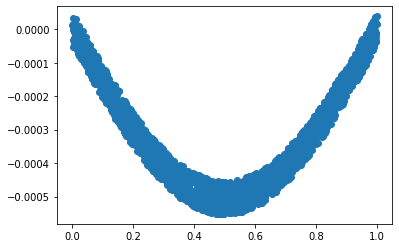

In [9]:
#plot the 1st entry of the dataframe
plt.scatter(fake_dataframe['x'][1],fake_dataframe['y'][1],label=str(fake_dataframe.index[1]))
plt.show()

In [10]:
#with the dataset organized is much easier to split the data.
#https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test
#let's take a look at an example 
test_split=0.1 #we will use 10% of the data for testing. 
df = fake_dataframe
train_df, test_df = train_test_split(df, test_size = test_split)

In [11]:
#the training data will be spllited automatically by 80/20 during training using keras framework. 
# no need to split at this stage.
#let's check the array shapes: 
print('Training set: ',train_df.shape)
print('Test set: ',test_df.shape)

train_size = train_df.shape[0]
test_size = test_df.shape[0]

Training set:  (57600, 6)
Test set:  (6400, 6)


C:\Users\luisf\.conda\envs\tf\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


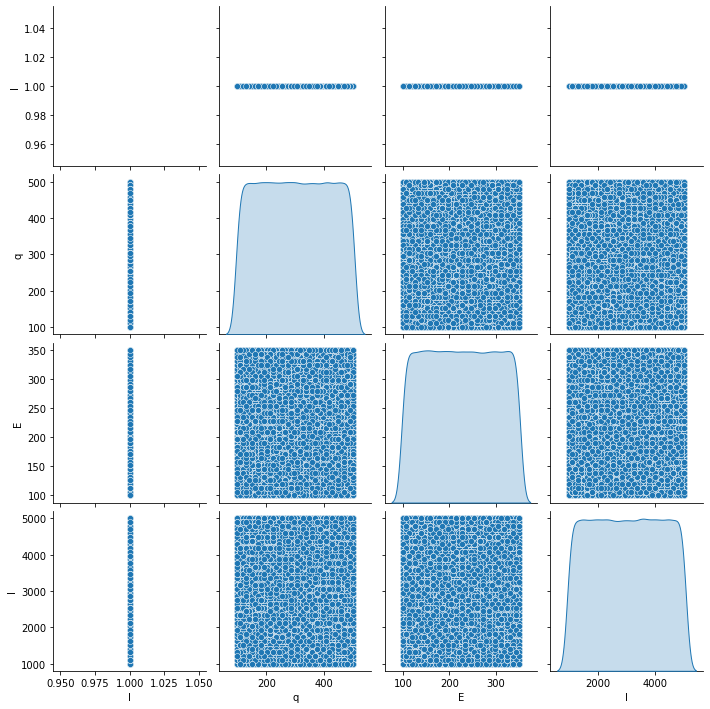

In [12]:
#inspect the training dataset
sns.pairplot(train_df[['l', 'q', 'E', 'I']], diag_kind='kde')

In [13]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
l,57600.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.0
q,57600.0,300.021368,118.331064,100.0,202.564103,294.871795,407.692308,500.0
E,57600.0,224.995103,73.976206,100.0,162.500000,221.794872,292.307692,350.0
I,57600.0,3001.000712,1184.037410,1000.0,2025.641026,3051.282051,4076.923077,5000.0


In [14]:
# follow this tutorial for our data 
# https://www.tensorflow.org/tutorials/keras/regression
# whenever possible, add comments and discussion

In [15]:
# get the max "y" for each entry
df.y.apply(min)
# at this point we could plot very interesting stuff such as ymax distributions on the vars (q,l,E,I)...
# but let's think about that later

0       -0.000199
1       -0.000552
2       -0.000740
3       -0.000755
4       -0.001806
           ...   
63995   -0.000767
63996   -0.000295
63997   -0.002731
63998   -0.000318
63999   -0.000399
Name: y, Length: 64000, dtype: float64

In [16]:
# I have fixed the value of L as 1.0 for now, so I am not using the values of [x,y] as inputs, only the values of y.

In [17]:
# Allocate the features and the labels in different DataFrames.

train_features = train_df.copy()
test_features = test_df.copy()

# train_labels = pd.DataFrame([train_features.pop('l'), train_features.pop('q'), train_features.pop('E'), train_features.pop('I')])
# train_labels = train_labels.T
# test_labels = pd.DataFrame([test_features.pop('l'), test_features.pop('q'), test_features.pop('E'), test_features.pop('I')])
# test_labels = test_labels.T

train_labels = pd.DataFrame([train_features.pop('q'), train_features.pop('E'), train_features.pop('I')])
train_labels = train_labels.T
test_labels = pd.DataFrame([test_features.pop('q'), test_features.pop('E'), test_features.pop('I')])
test_labels = test_labels.T

In [18]:
feature_columns = []

# Will not include the values of x
# x_col = tf.feature_column.numeric_column("x")
# feature_columns.append(x_col)
y_col = tf.feature_column.numeric_column("y")
feature_columns.append(y_col)

my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [19]:
# Build the model and define its architecture.

In [20]:
inputs = keras.Input(shape=n)

In [21]:
dense = layers.Dense(512, activation="relu")
x = dense(inputs)

In [22]:
x = layers.Dense(512, activation="relu")(x)
outputs = layers.Dense(3)(x)

In [23]:
model = keras.Model(inputs=inputs, outputs=outputs, name="model")

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2000)]            0         
_________________________________________________________________
dense (Dense)                (None, 512)               1024512   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1539      
Total params: 1,288,707
Trainable params: 1,288,707
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Set the hyperparameters

validation_split=0.2
learning_rate = 0.0001
batch_size = 50
epochs = 20

In [26]:
model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
)

# Still need to find what's the best loss function for our model.

In [27]:
# For some reason I had to manually convert the data into tensors.

tf_train_features = tf.constant([train_features['y']], shape=(train_size,n))

tf_train_labels = tf.constant([np.array(train_labels)], shape=(train_size,3))

tf_test_features = tf.constant([test_features['y']], shape=(test_size,n))

tf_test_labels = tf.constant([np.array(test_labels)], shape=(test_size,3))

In [28]:
history = model.fit(tf_train_features, tf_train_labels, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

test_scores = model.evaluate(tf_train_features, tf_train_labels, verbose=2)
print("Test loss:", test_scores)

Epoch 1/20
922/922 [==============================] - 10s 10ms/step - loss: 3319596.0000 - val_loss: 2786944.2500
Epoch 2/20
922/922 [==============================] - 9s 10ms/step - loss: 2023500.5000 - val_loss: 1407782.7500
Epoch 3/20
922/922 [==============================] - 10s 10ms/step - loss: 1212435.1250 - val_loss: 1047957.3125
Epoch 4/20
922/922 [==============================] - 9s 10ms/step - loss: 901703.7500 - val_loss: 759899.1250
Epoch 5/20
922/922 [==============================] - 9s 10ms/step - loss: 635836.5625 - val_loss: 524316.3125
Epoch 6/20
922/922 [==============================] - 10s 10ms/step - loss: 439893.5000 - val_loss: 377089.1250
Epoch 7/20
922/922 [==============================] - 9s 10ms/step - loss: 344963.5000 - val_loss: 330176.8750
Epoch 8/20
922/922 [==============================] - 9s 10ms/step - loss: 322285.5000 - val_loss: 323451.5000
Epoch 9/20
922/922 [==============================] - 9s 9ms/step - loss: 319211.9688 - val_loss: 32238

1727172.09375


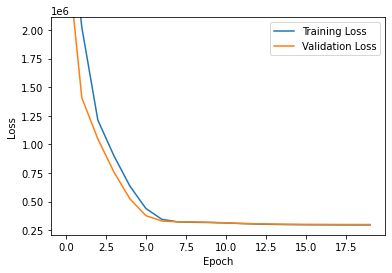

In [29]:
epochs = history.epoch

hist = history.history

plot_the_loss_curve(epochs, hist["loss"], 
                    hist["val_loss"])

In [30]:
tf_test_labels[0:5]

# q; E; I

<tf.Tensor: shape=(5, 3), dtype=float64, numpy=
array([[ 202.56410256,  292.30769231, 3256.41025641],
       [ 448.71794872,  151.28205128, 4589.74358974],
       [ 141.02564103,  208.97435897, 2641.02564103],
       [ 202.56410256,  298.71794872, 1717.94871795],
       [ 120.51282051,  170.51282051, 4897.43589744]])>

In [31]:
model.predict(tf_test_features)[0:5]

# q; E; I

array([[ 222.0618 ,  259.59073, 3750.602  ],
       [ 338.65814,  216.34933, 2762.951  ],
       [ 233.86041,  255.2814 , 3651.7524 ],
       [ 272.0351 ,  241.30565, 3331.3818 ],
       [ 203.30902,  266.4665 , 3908.1482 ]], dtype=float32)

In [32]:
# relative error (%)

(np.abs(tf_test_labels[0:5] - model.predict(tf_test_features)[0:5]) / tf_test_labels[0:5]) * 100

<tf.Tensor: shape=(5, 3), dtype=float64, numpy=
array([[ 9.62544463, 11.19264542, 15.17596849],
       [24.52761405, 43.01057719, 39.80162783],
       [65.82829257, 22.15919878, 38.27023807],
       [34.2958065 , 19.21956821, 93.91625612],
       [68.70323019, 56.2735816 , 20.20011542]])>

In [33]:
error_mat = (np.abs(tf_test_labels - model.predict(tf_test_features)) / tf_test_labels) * 100

error_avg = np.array([0,0,0])
error_avg[0] = np.average(error_mat[:,0])
error_avg[1] = np.average(error_mat[:,1])
error_avg[2] = np.average(error_mat[:,2])

error_avg

# average relative error (%) for [q, E, I]

array([34, 28, 32])

In [34]:
def compare_curves(label, guess, n):

    label = [1, label[0], label[1],label[2]]
    guess = [1, guess[0], guess[1], guess[2]]
    
    x_vec = np.linspace(0, 1, n)
    y_vec = ana_sol(n, label)[1] * 10**3  # [mm]

    points = np.zeros((len(x_vec), 2))

    for i in range(len(x_vec)):
        points[i, 0] = x_vec[i]
        points[i, 1] = y_vec[i]
    
    y_vec_g = ana_sol(n, guess)[1] * 10**3  # [mm]

    points = np.zeros((len(x_vec), 2))

    for i in range(len(x_vec)):
        points[i, 0] = x_vec[i]
        points[i, 1] = y_vec[i]


    plt.plot(x_vec, y_vec, c='g')
    plt.plot(x_vec, y_vec_g, c='r')
    plt.show()

In [35]:
# error_col will contain the average of the relative errors (%) for q, E and I for each guess.

error_col = (error_mat[:,0] + error_mat[:,1] + error_mat[:,2])/3

error_col[0:10]

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([11.99801951, 35.77993969, 42.08590981, 49.14387694, 48.39230907,
       48.86308388, 31.2037567 , 28.29171362, 19.80909433, 42.95286544])>

In [36]:
np.min(error_col)

0.6672596558815632

In [37]:
# Relative errors (%) for q, E, I for our best curve.
np.array(error_mat[np.argmin(error_col),:])

array([0.0549214 , 1.21866176, 0.7281958 ])

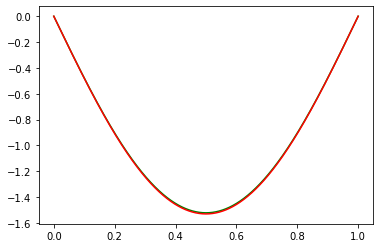

In [38]:
# This is the best guess (the guess which as the minimum average error)
# "True" curve is in green, whereas the "guessed" curve is in red.

min_label = np.array(tf_test_labels[np.argmin(error_col),:])
min_guess = model.predict(tf_test_features)[np.argmin(error_col),:]

compare_curves(min_label, min_guess, n)

In [39]:
np.max(error_col)

161.1935904300574

In [40]:
# Relative errors (%) for q, E, I for our worst curve.
np.array(error_mat[np.argmax(error_col),:])

array([280.58312988,  72.47928203, 130.51835938])

In [41]:
np.array(tf_test_labels[np.argmax(error_col),:])

array([ 100.        ,  112.82051282, 1000.        ])

In [42]:
model.predict(tf_test_features)[np.argmax(error_col),:]

array([ 380.58313,  194.59201, 2305.1836 ], dtype=float32)

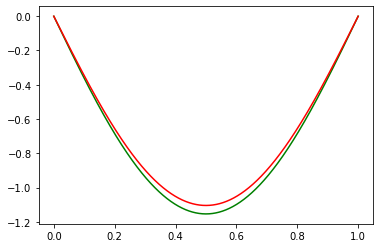

In [43]:
# This is the worst guess (the guess which as the maximum average error)
# "True" curve is in green, whereas the "guessed" curve is in red.

max_label = tf_test_labels[np.argmax(error_col),:]
max_guess = model.predict(tf_test_features)[np.argmax(error_col),:]

compare_curves(max_label, max_guess, n)

The errors for q, E and I (%) are: [4.55675627e-03 7.82188394e+00 1.70029445e+01]


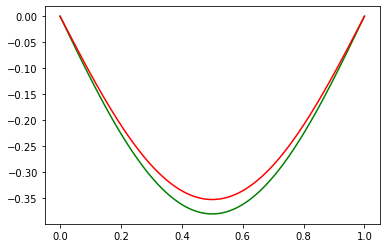

In [44]:
# The curve with less error for q.
i_min_q = np.argmin(error_mat, axis=0)[0]

print('The errors for q, E and I (%) are:', np.array(error_mat[i_min_q,:]))

min_q_label = tf_test_labels[i_min_q,:]
min_q_guess = model.predict(tf_test_features)[i_min_q ,:]

compare_curves(min_q_label, min_q_guess, n)

The errors for q, E and I (%) are: [6.96042175e+01 6.58222273e-05 7.86532916e+01]


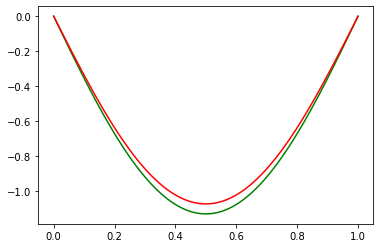

In [45]:
# The curve with less error for E.
i_min_E = np.argmin(error_mat, axis=0)[1]

print('The errors for q, E and I (%) are:', np.array(error_mat[i_min_E,:]))

min_E_label = tf_test_labels[i_min_E,:]
min_E_guess = model.predict(tf_test_features)[i_min_E ,:]

compare_curves(min_E_label, min_E_guess, n)

The errors for q, E and I (%) are: [2.43363031e+01 1.87303876e+01 8.17948191e-03]


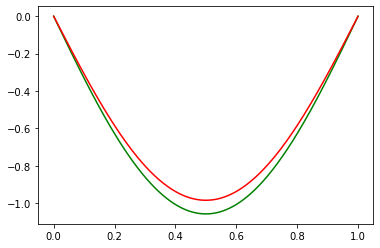

In [46]:
# The curve with less error for I.
i_min_I = np.argmin(error_mat, axis=0)[2]

print('The errors for q, E and I (%) are:', np.array(error_mat[i_min_I,:]))

min_I_label = tf_test_labels[i_min_I,:]
min_I_guess = model.predict(tf_test_features)[i_min_I ,:]

compare_curves(min_I_label, min_I_guess, n)

The errors for q, E and I (%) are: [280.58312988  72.47928203 130.51835938]


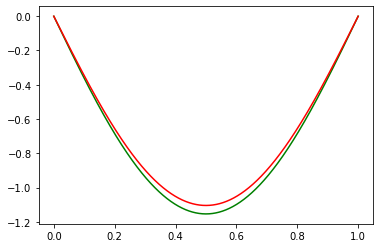

In [47]:
# The curve with more error for q.
i_min_q = np.argmax(error_mat, axis=0)[0]

print('The errors for q, E and I (%) are:', np.array(error_mat[i_min_q,:]))

min_q_label = tf_test_labels[i_min_q,:]
min_q_guess = model.predict(tf_test_features)[i_min_q ,:]

compare_curves(min_q_label, min_q_guess, n)

The errors for q, E and I (%) are: [108.1654035  156.8671875   19.64401774]


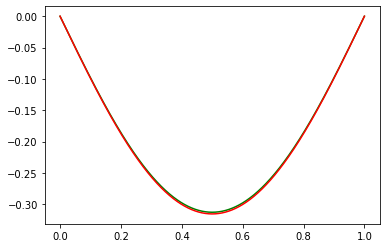

In [48]:
# The curve with more error for E.
i_min_E = np.argmax(error_mat, axis=0)[1]

print('The errors for q, E and I (%) are:', np.array(error_mat[i_min_E,:]))

min_E_label = tf_test_labels[i_min_E,:]
min_E_guess = model.predict(tf_test_features)[i_min_E ,:]

compare_curves(min_E_label, min_E_guess, n)

The errors for q, E and I (%) are: [146.49784851  24.22453982 254.54833984]


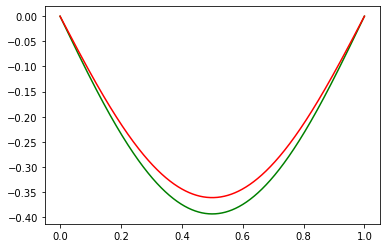

In [49]:
# The curve with more error for I.
i_min_I = np.argmax(error_mat, axis=0)[2]

print('The errors for q, E and I (%) are:', np.array(error_mat[i_min_I,:]))

min_I_label = tf_test_labels[i_min_I,:]
min_I_guess = model.predict(tf_test_features)[i_min_I ,:]

compare_curves(min_I_label, min_I_guess, n)

In [50]:
# 07/08/2021

# There is no point in trying to guess L in this case, as there is only one value for it.

# Even for multiple values of L, I think that it doesn't make sense to have [x, y] as inputs and at the same time try to 
# guess L, at least in the way I was innitially doing, because, (as the x values are linnearly spaced and allways the same
# for each L), we could easily check the max value of x and get L from that, without any need for a machine learning method.

In [51]:
# 07/08/2021

# Need to improve the way I feed the data to the model (had to extract it from DataFrames and convert the arrays to tensors...)

# Will try to figure out the best loss function, the best architecture for the model,
# tune the hyperparameters and try to get good results.

In [52]:
# 12/09/2021

# I am now only trying to find 3 parameters: E, q and I, as L was set to 1.0.

# After some tunning and experimenting, I'm still not able to say if the problem is with the architecture
# of the model being still too simple, if the problem is with the loss function or if it has to due with
# the lack of normalization of the features. I've noticed that the model is very bad at guessing
# the values for I, which are very small.

In [53]:
# 18/09/2021

# Adjusted the units of q, E and I. This way the values of the loss function don't get too high, they were
# often turning into NaN when I tryed to adjust the model or increase the number of [x,y] inputs.
# This way it is also easier to read the resuts.

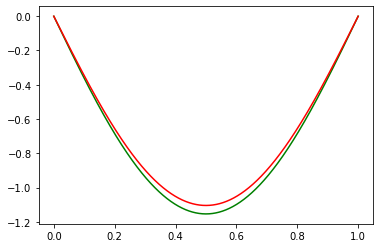

In [54]:
# 28/09/2021

# Tried out the model with 64000 combinations. Running time around 3 minutes.
# The average error hasn't gone down, but the curves are apperently much better.
# Even the "worst curve", which for 
# q = 100; E = 112.82051282; I = 1000 guessed
# q = 380.58313; E = 194.59201; I = 2305.1836,
# with an average relative error of 161.2%,
# is quite similar to the true curve, as we can see below.

compare_curves([100, 112.82051282, 1000], [380.58313,], n)